In [1]:
from reprowd.crowdcontext import CrowdContext
from reprowd.presenter.base import BasePresenter

In [2]:
cc = CrowdContext(local_db="sketch.db")

In [3]:
import os
def gen_img_list(folder_path):
    img_list = []
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        if file_name.endswith('.bmp'):
            img_list.append('\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/' + file_name)
    return img_list

In [4]:
crowd_data = cc.CrowdData(gen_img_list('../../out_img'), 'image_regions')

with open('presenter.html') as presenter_file:
    my_presenter = BasePresenter()
    my_presenter.set_name("Crowd_Sketch_Filter")
    my_presenter.set_description("This is a description")
    my_presenter.set_question("question?")
    my_presenter.set_short_name("csf")
    
    my_presenter.set_template(presenter_file.read())
    crowd_data.set_presenter(my_presenter, lambda obj: {'url_m': obj})

In [5]:
r = crowd_data.publish_task(n_assignments=1)

In [9]:
crowd_data = crowd_data.get_result()

In [17]:
import base64
from PIL import Image
from io import BytesIO
import re

def gather_images():
    results = []
    for i in crowd_data.data['id']:
        result_obj = {}
        m = re.search('([0-9]+_[0-9]+_[0-9]+_[0-9]+).[a-zA-Z]+', crowd_data.data['object'][i])
        result_obj['file'] = m.group(1)
        result_obj['img'] = []
        for a in crowd_data.data['result'][i]['assignments']:
            im = Image.open(BytesIO(base64.b64decode(a['worker_response'][23:])))
            result_obj['img'].append(im)
        results.append(result_obj)
    return results

gather_images()
            

[{'file': '0_0_103_103',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x1065C1890>]},
 {'file': '0_103_103_206',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x1065C1A10>]},
 {'file': '0_206_103_308',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x102 at 0x1065C1A50>]},
 {'file': '0_308_103_410',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x102 at 0x1065C1F50>]},
 {'file': '0_410_103_512',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x102 at 0x1065C1D50>]},
 {'file': '103_0_206_103',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x1065C1BD0>]},
 {'file': '103_103_206_206',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x1065C19D0>]},
 {'file': '103_206_206_308',
  'img': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x102 at 0x1065C1E90>]},
 {'file': '103_308_206_410',
  'img': [<PIL.Jp

{'id': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 'object': ['\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/0_0_103_103.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/0_103_103_206.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/0_206_103_308.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/0_308_103_410.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/0_410_103_512.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/103_0_206_103.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/103_103_206_206.bmp',
  '\nhttps://raw.githubusercontent.com/wmaciel/crowd-sketch-filter/master/out_img/103_206_206_308.bmp',
  '\nhttps://raw.githubus
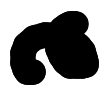
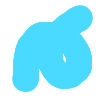
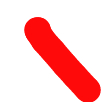
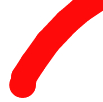
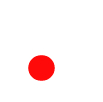
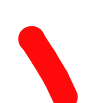
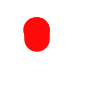
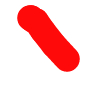
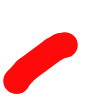
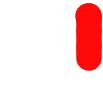
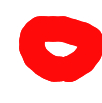
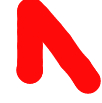
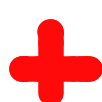
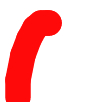
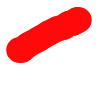
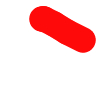
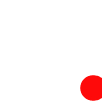
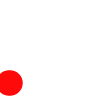
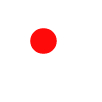
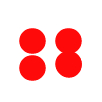
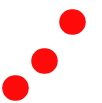
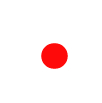
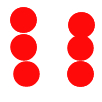
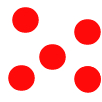
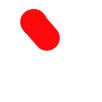